# Indicateur données officielles

In [3]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import itertools
import statsmodels.api as sm

from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore")

In [6]:
#Fonction qui réduit la base des données officielles à 1 seul département :

def reduc_base_departement(departement):
    
    #Importe données groupées par mois
    df_France_Official_Data2 = pd.read_csv("df_France_Official_Data_month.csv", index_col=0)
    df_France_Official_Data2['date'] = pd.to_datetime(df_France_Official_Data2['date'])
    
    #Données département
    df_Official_Data_dep = df_France_Official_Data2[df_France_Official_Data2['department']==departement]
    
    #On regroupe par mois
    df_Official_Data_dep2 = df_Official_Data_dep.groupby('date').sum() 

    return(df_Official_Data_dep2)

In [8]:
#reduc_base_departement("Paris")

In [18]:
def choix_modele_sarima(pmax, dmax, qmax, data):

    p = range(0, pmax)
    q = range(0, qmax)
    d = range(0, dmax)
    pdq = list(itertools.product(p, d, q))

    p2 = d2 = q2 = range(0, 2)
    seasonal_pdq = list(itertools.product(p2,d2,q2))
    seasonal_pdq = [(x[0], x[1], x[2], 12) for x in seasonal_pdq]
    
    parametres_aic = {}
    parametres_bic = {}
    aics = []
    bics = []

    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(data,
                                                order=param,
                                                seasonal_order=param_seasonal,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)
                results = mod.fit()
                parametres_aic.update({results.aic : [param, param_seasonal]})
                parametres_bic.update({results.bic : [param, param_seasonal]})
                aics.append(results.aic)
                bics.append(results.bic)


            except: 
                continue

    best_aic = min(aics)
    best_bic = min(bics)

    print(parametres_bic[best_bic])
    
    return(parametres_bic[best_bic])

In [21]:
def modele_donnees_off(departement, pmax, dmax, qmax):
    
    #on importe les données officielles pour le département demandé
    df_Official_Data_dep = reduc_base_departement(departement)
    df_Official_Data_dep_index = df_Official_Data_dep.reset_index()
   
    #on imagine que l'on a toutes les données jusqu'à décembre 2016 de disponibles
    df_donnees_dispo = df_Official_Data_dep_index[df_Official_Data_dep_index['date']<"2017-01-01"]
    df_donnees_dispo.set_index('date', inplace=True)

    
    #choix du modèle qui minimise le BIC
    parametres_modele = choix_modele_sarima(pmax, dmax, qmax, df_donnees_dispo)
    
    #on fit le modèle sur ces données
    modele_prev = sm.tsa.statespace.SARIMAX(df_donnees_dispo,
                                            order=parametres_modele[0],
                                            seasonal_order=parametres_modele[1],
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

    resultats_prev = modele_prev.fit()
    
    
    #on crée le dataframe des prévisions qu'on va remplir au fur et à mesure

    df_forecast = pd.DataFrame(columns=['date', 'valeur_predite','donnee_officielle'])
    df_forecast['date'] = df_Official_Data_dep_index['date'][(df_Official_Data_dep_index['date']<'2021-10-01') &
                                                               (df_Official_Data_dep_index['date']>="2017-01-01")]
    df_forecast.set_index('date', drop=False, inplace=True)
    
    
    #on remplit la base
    
    resultats_prev_new = resultats_prev

    for date in df_forecast['date']:

        #La valeur prédite :
        if ( float(resultats_prev_new.forecast(date)) >= 0):
            df_forecast.loc[date, 'valeur_predite'] = float(resultats_prev_new.forecast(date)) 
        else:
            df_forecast.loc[date, 'valeur_predite'] = 0
        #je mets dans le dataframe la prédiction pour la date

        # La nouvelle observation qu'on a à disposition
        new_data = df_Official_Data_dep.loc[date, "value_in_thousands"]

        #La nouvelle observation qu'on a à disposition (sous forme de dataframe) :
        new_data2 = df_Official_Data_dep_index[df_Official_Data_dep_index['date']==date]
        new_data2.set_index('date', inplace=True)

        #On met la nouvelle observation dans le dataframe
        df_forecast.loc[date, 'donnee_officielle'] = new_data

        #Nouveau modèle fitté avec une donnée de plus :
        resultats_prev_new = resultats_prev_new.append(new_data2)

        
    df_forecast[['valeur_predite','donnee_officielle']].plot(figsize=(15,6))
    
    return(df_forecast)

[(0, 1, 3), (0, 1, 1, 12)]


,date,valeur_predite,donnee_officielle
date,,,
2017-01-01,2017-01-01,1093.506807,1186.08
2017-02-01,2017-02-01,1112.11251,1073.42
2017-03-01,2017-03-01,1265.499091,1361.99
2017-04-01,2017-04-01,1305.759437,1340.15
2017-05-01,2017-05-01,1396.526396,1369.79
2017-06-01,2017-06-01,1399.971174,1489.54
2017-07-01,2017-07-01,1391.790929,1482.79
2017-08-01,2017-08-01,1285.254259,1203.31
2017-09-01,2017-09-01,1355.483141,1467.68


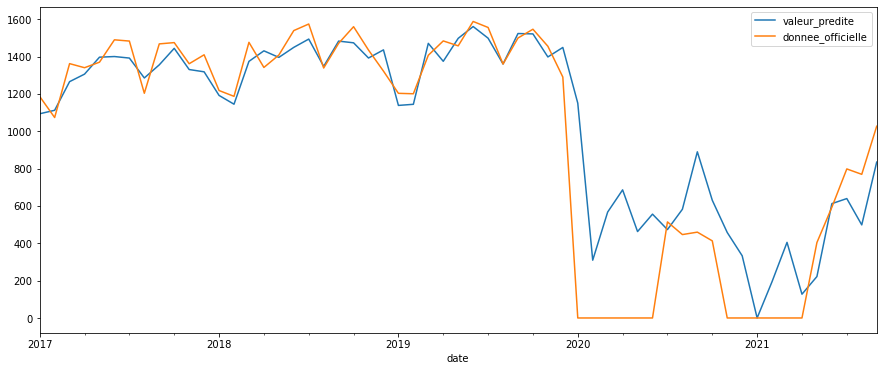

In [22]:
 modele_donnees_off("Paris", 4, 2, 4)